In [1]:
# Cell 1: imports & display settings
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Cell 2: load data
path = "../data/cleaned/final_merged_dataset.csv"   # change path if needed
df = pd.read_csv(path)
print("Dataset shape:", df.shape)
display(df.head())
print("Columns:", list(df.columns))


Dataset shape: (6930, 18)


,State,Crime_Type,Year,Cases,unemployment_rate,poverty_rate,per_capita_income,inflation_rate,population_density,gender_ratio,literacy_rate,youth_population_percent,urbanization_rate,human_development_index,police_stations_per_district,conviction_rate,police_personnel_per_100k,alcohol_consumption_per_capita
0,Andaman & Nicobar Islands,Burglary,2001,57,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3
1,Andaman & Nicobar Islands,Dacoity,2001,7,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3
2,Andaman & Nicobar Islands,Dowry Deaths,2001,0,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3
3,Andaman & Nicobar Islands,Kidnapping & Abduction,2001,33,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3
4,Andaman & Nicobar Islands,Murder,2001,10,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3


Columns: ['State', 'Crime_Type', 'Year', 'Cases', 'unemployment_rate', 'poverty_rate', 'per_capita_income', 'inflation_rate', 'population_density', 'gender_ratio', 'literacy_rate', 'youth_population_percent', 'urbanization_rate', 'human_development_index', 'police_stations_per_district', 'conviction_rate', 'police_personnel_per_100k', 'alcohol_consumption_per_capita']


In [3]:
X = df.drop("Cases", axis=1)   # all columns except Cases
y = df["Cases"]                # target variable


In [4]:
# STEP 5: Separate categorical & numerical columns

cat_cols = ["State", "Crime_Type"]
num_cols = [col for col in X.columns if col not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)


Categorical columns: ['State', 'Crime_Type']
Numerical columns: ['Year', 'unemployment_rate', 'poverty_rate', 'per_capita_income', 'inflation_rate', 'population_density', 'gender_ratio', 'literacy_rate', 'youth_population_percent', 'urbanization_rate', 'human_development_index', 'police_stations_per_district', 'conviction_rate', 'police_personnel_per_100k', 'alcohol_consumption_per_capita']


In [5]:
# STEP 6: Preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)


In [6]:
# STEP 7: Train-Val-Test Split based on Year

train_df = df[df["Year"] <= 2020]
#val_df   = df[(df["Year"] >= 2018) & (df["Year"] <= 2020)]
test_df  = df[df["Year"] >= 2021]

print("Train shape:", train_df.shape)
#print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (6300, 18)
Test shape: (630, 18)


In [7]:
# Features & Target

X_train = train_df.drop("Cases", axis=1)
y_train = train_df["Cases"]

X_test = test_df.drop("Cases", axis=1)
y_test = test_df["Cases"]


In [8]:
# Fit on training
preprocessor.fit(X_train)

# Transform
X_train_transformed = preprocessor.transform(X_train)
#X_val_transformed   = preprocessor.transform(X_val)
X_test_transformed  = preprocessor.transform(X_test)
print("Train shape:", X_train_transformed.shape)
#print("Validation shape:", X_val_transformed.shape)
print("Test shape:", X_test_transformed.shape)

Train shape: (6300, 59)
Test shape: (630, 59)


In [9]:
# =======  Train a baseline Random Forest =======
rf = RandomForestRegressor(
    n_estimators=100,    # start with 100 trees
    max_depth=None,      # let trees grow fully (we'll tune later)
    random_state=42,
    n_jobs=-1
)

# Fit on training data (transformed)
rf.fit(X_train_transformed, y_train)

# Predict on train and test
y_train_pred = rf.predict(X_train_transformed)
y_test_pred  = rf.predict(X_test_transformed)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test  = mean_absolute_error(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("✅ Baseline Random Forest (100 trees) Evaluation")
print(f"Train R²: {r2_train:.4f} | Test R²: {r2_test:.4f}")
print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")



✅ Baseline Random Forest (100 trees) Evaluation
Train R²: 0.9491 | Test R²: 0.6847
Train MAE: 449.41 | Test MAE: 1078.15
Train RMSE: 1841.97 | Test RMSE: 3940.96


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define parameter ranges (light & effective)
param_dist = {
    'n_estimators': randint(50, 150),       # number of trees
    'max_depth': [10, 15, None],            # tree depth
    'min_samples_split': randint(2, 6),     # min samples for split
    'min_samples_leaf': randint(1, 3)       # min samples per leaf
}

# Base model
rf = RandomForestRegressor(random_state=42, n_jobs=2)  # use 2 cores (keeps system cooler)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,          # only 10 random combos
    cv=2,               # 2-fold cross-validation (faster)
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=2
)

# Fit search
random_search.fit(X_train_transformed, y_train)

# Best results
print("✅ Randomized Search Completed!")
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation R²:", f"{random_search.best_score_:.4f}")

# Evaluate best model on test data
best_rf = random_search.best_estimator_
y_test_pred = best_rf.predict(X_test_transformed)

r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\n✅ Tuned Random Forest Performance:")
print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")


Fitting 2 folds for each of 10 candidates, totalling 20 fits
✅ Randomized Search Completed!
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 96}
Best Cross-Validation R²: 0.4792

✅ Tuned Random Forest Performance:
Test R²: 0.6993
Test MAE: 1067.22
Test RMSE: 3848.54


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# List of parameter combinations to test manually
param_combos = [
    {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2},
    {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}
]

results = []

for params in param_combos:
    rf = RandomForestRegressor(**params, random_state=42, n_jobs=2)
    rf.fit(X_train_transformed, y_train)
    
    y_pred_train = rf.predict(X_train_transformed)
    y_pred_test  = rf.predict(X_test_transformed)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    results.append({
        'Params': params,
        'Train R²': round(r2_train, 3),
        'Test R²': round(r2_test, 3),
        'Test RMSE': round(rmse_test, 2),
        'Test MAE': round(mae_test, 2)
    })

# Display results neatly
import pandas as pd
pd.DataFrame(results)


,Params,Train R²,Test R²,Test RMSE,Test MAE
0,"{'n_estimators': 100, 'max_depth': None, 'min_...",0.949,0.685,3940.96,1078.15
1,"{'n_estimators': 150, 'max_depth': 15, 'min_sa...",0.947,0.707,3800.57,1051.42
2,"{'n_estimators': 200, 'max_depth': 20, 'min_sa...",0.948,0.695,3878.85,1077.20
3,"{'n_estimators': 150, 'max_depth': 20, 'min_sa...",0.906,0.708,3792.62,1055.09
4,"{'n_estimators': 200, 'max_depth': None, 'min_...",0.928,0.702,3833.96,1065.90


In [12]:
'''param_grid = {'n_estimators':[100,200], 'max_depth':[None,10,20], 'min_samples_leaf':[1,2,5]}
best_score = np.inf; best_params=None; best_model=None
for n in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
        for leaf in param_grid['min_samples_leaf']:
            model = RandomForestRegressor(n_estimators=n, max_depth=depth, min_samples_leaf=leaf,
                                          random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)
            yv = model.predict(X_val)
            mae_val = mean_absolute_error(y_val, yv)
            if mae_val < best_score:
                best_score = mae_val
                best_params = {'n_estimators':n,'max_depth':depth,'min_samples_leaf':leaf}
                best_model = model
print("best:", best_params, "val_mae:", best_score)'''


'param_grid = {\'n_estimators\':[100,200], \'max_depth\':[None,10,20], \'min_samples_leaf\':[1,2,5]}\nbest_score = np.inf; best_params=None; best_model=None\nfor n in param_grid[\'n_estimators\']:\n    for depth in param_grid[\'max_depth\']:\n        for leaf in param_grid[\'min_samples_leaf\']:\n            model = RandomForestRegressor(n_estimators=n, max_depth=depth, min_samples_leaf=leaf,\n                                          random_state=42, n_jobs=-1)\n            model.fit(X_train, y_train)\n            yv = model.predict(X_val)\n            mae_val = mean_absolute_error(y_val, yv)\n            if mae_val < best_score:\n                best_score = mae_val\n                best_params = {\'n_estimators\':n,\'max_depth\':depth,\'min_samples_leaf\':leaf}\n                best_model = model\nprint("best:", best_params, "val_mae:", best_score)'

In [20]:

'''# Cell 10: test evaluation
y_test_pred = best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test  = r2_score(y_test, y_test_pred)

print("TEST EVALUATION (2021-2022):")
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("R2:", round(r2_test,3))'''



'# Cell 10: test evaluation\ny_test_pred = best_model.predict(X_test)\n\nmae_test = mean_absolute_error(y_test, y_test_pred)\nrmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))\nr2_test  = r2_score(y_test, y_test_pred)\n\nprint("TEST EVALUATION (2021-2022):")\nprint("MAE:", round(mae_test,3))\nprint("RMSE:", round(rmse_test,3))\nprint("R2:", round(r2_test,3))'

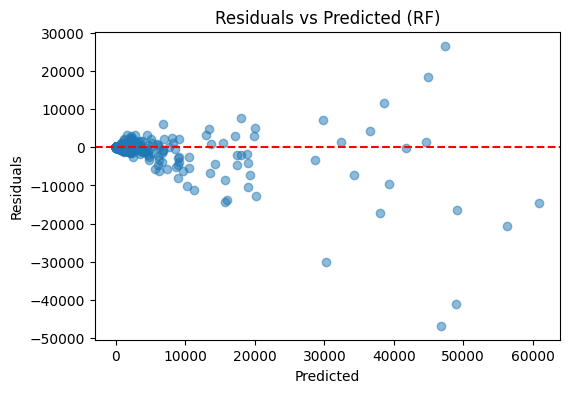

In [21]:
residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (RF)")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


In [15]:
'''importances = best_model.feature_importances_
feat = X_train.columns
fi = pd.Series(importances, index=feat).sort_values(ascending=False)[:20]
fi.plot.bar(figsize=(10,4))
plt.title("Top feature importances")
plt.show()
'''

'importances = best_model.feature_importances_\nfeat = X_train.columns\nfi = pd.Series(importances, index=feat).sort_values(ascending=False)[:20]\nfi.plot.bar(figsize=(10,4))\nplt.title("Top feature importances")\nplt.show()\n'

In [ ]:
'''plt.figure(figsize=(10,6))
plot_tree(best_model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, fontsize=8)
plt.show()
'''

'plt.figure(figsize=(10,6))\nplot_tree(best_model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, fontsize=8)\nplt.show()\n'

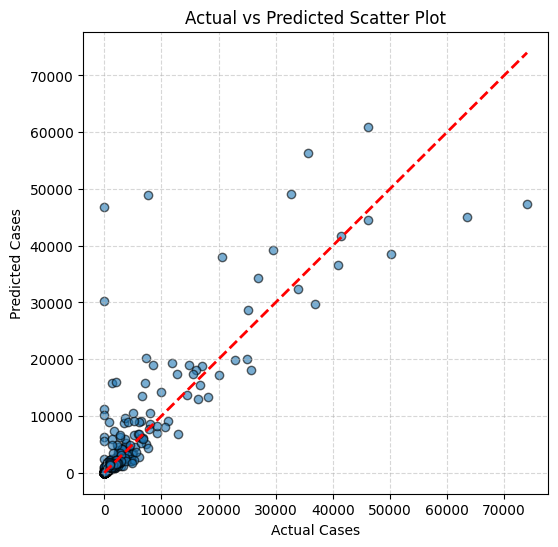

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Scatter Plot")
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [18]:
'''os.makedirs("../model", exist_ok=True)
joblib.dump(best_model, "../model/random_forest_time_model.pkl")
joblib.dump(encoders, "../model/rf_time_encoders.pkl")
joblib.dump(X_train.columns.tolist(), "../model/rf_time_feature_columns.pkl")
'''

'os.makedirs("../model", exist_ok=True)\njoblib.dump(best_model, "../model/random_forest_time_model.pkl")\njoblib.dump(encoders, "../model/rf_time_encoders.pkl")\njoblib.dump(X_train.columns.tolist(), "../model/rf_time_feature_columns.pkl")\n'